In [1]:
import torch
import torch.nn as nn
import numpy as np
import numpy.random as rng
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
X = np.load('./data/X_rho0_N50_p200.npy')
normalize_c = np.load('./data/normalize_constant_rho0.npy')
train_losses = np.load('./results/train_losses_rho0.npy')
val_losses = np.load('./results/val_losses_rho0.npy')

In [4]:
train_losses_rho06 = np.load('./results/train_losses_rho06.npy')
val_losses_rho06 = np.load('./results/val_losses_rho06.npy')
X_rho06 = np.load('./data/X_rho06_N50_p200.npy')
normalize_c_rho_06 = np.load('./data/normalize_constant_rho06.npy')

In [7]:
class Generator(object):
    def __init__(self, p, theta, beta_range, N, X, cat_XtY=False) -> None:
        self.p = p
        self.theta = theta
        self.beta_range = beta_range
        self.N = N
        self.X = X
        self.cat_XtY = cat_XtY
        self.normalize_c = 1.

    def generate_samples(self, n, sigma=1):
        scale = self.beta_range[1] - self.beta_range[0]
        # every beta has the same theta
        theta = np.ones((n, self.p)) * self.theta
        gamma = rng.binomial(1, theta)
        beta = np.zeros((n, self.p))
        beta[gamma == 1] = rng.rand(
            np.sum(gamma == 1)) * scale + self.beta_range[0]
        beta[gamma == 0] = 0.
        Y = beta@self.X.T + rng.randn(n, self.N) * sigma
        if self.cat_XtY:
            Y = np.concatenate((Y, Y @ self.X), axis=1)
        return gamma, beta, Y/self.normalize_c

In [8]:
p = 200
N = 50
theta = 0.05
beta_range = (-3, 3)
generator = Generator(p, theta, beta_range, N, X, True)

In [85]:
generator_rho06 = Generator(p, theta, beta_range, N, X_rho06, True)

In [30]:
gamma_test, beta_test, Y_test = generator.generate_samples(100000)

In [61]:
gamma_test_rho06, beta_test_rho06, Y_test_rho06 = generator_rho06.generate_samples(100000)

In [42]:
np.save('./data/gamma_test_rho0', gamma_test)
np.save('./data/beta_test_rho0', beta_test)
np.save('./data/Y_test_rho0', Y_test)

In [16]:
np.mean(beta_test**2)

0.14989306138573258

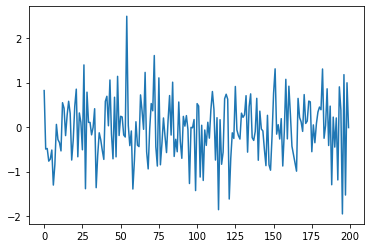

In [20]:
plt.plot(X.T @ Y_test[1,:50] / 50)

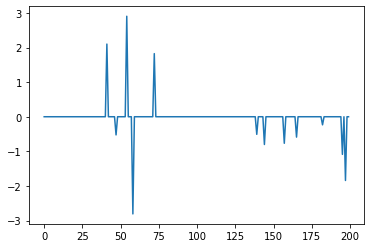

In [21]:
plt.plot(beta_test[1])

In [118]:
beta_obs = np.zeros((200,1))
beta_obs[:4,0] = 2.
Y_obs = X @ beta_obs + rng.randn(50,1)

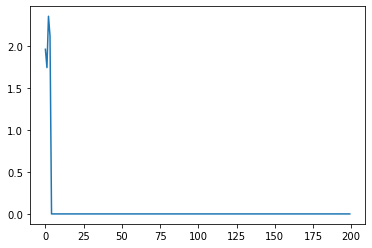

In [120]:
a = X.T @ Y_obs / 50
a[np.abs(a)<1.7] = 0
plt.plot(a)

In [121]:
beta_obs = np.zeros((200,1))
beta_obs[:10,0] = 2.
Y_obs = X @ beta_obs + rng.randn(50,1)

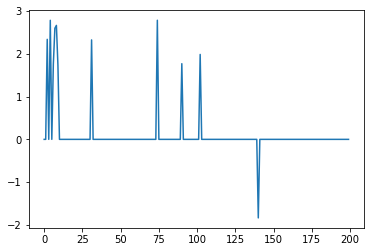

In [125]:
a = X.T @ Y_obs / 50
a[np.abs(a)<1.7] = 0
plt.plot(a)

In [106]:
(X.T @ Y_obs / 50)[:10]

array([[ 2.02931796],
       [ 1.60554821],
       [ 2.24229782],
       [ 1.90872544],
       [ 0.29014827],
       [-0.57518101],
       [-0.62918957],
       [-0.16760127],
       [-0.03249399],
       [-0.4931745 ]])

In [36]:
train_losses_promax = np.load('train_losses_promax.npy')
val_losses_promax = np.load('val_losses_promax.npy')

In [5]:
normalize_c

array(567.64196324)

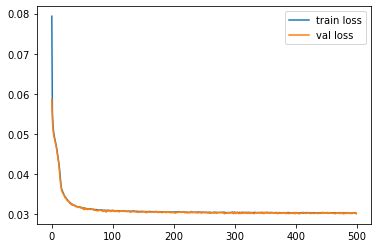

In [29]:
plt.plot(range(train_losses.shape[0]), train_losses)
plt.plot(range(train_losses.shape[0]), val_losses)
plt.legend(['train loss', 'val loss'], loc="upper right")
plt.show()

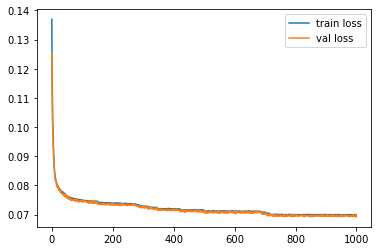

In [59]:
plt.plot(range(train_losses_rho06.shape[0]), train_losses_rho06)
plt.plot(range(train_losses_rho06.shape[0]), val_losses_rho06)
plt.legend(['train loss', 'val loss'], loc="upper right")
plt.show()

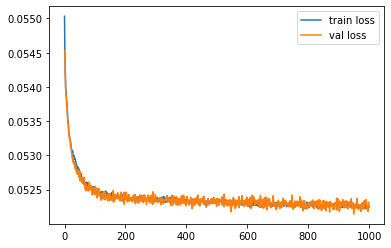

In [37]:
plt.plot(range(train_losses_promax.shape[0]), train_losses_promax)
plt.plot(range(train_losses_promax.shape[0]), val_losses_promax)
plt.legend(['train loss', 'val loss'], loc="upper right")
plt.show()

In [4]:
class MLP(nn.Module):
    def __init__(self, N, p):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(N, 1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 2048)
        self.fc4 = nn.Linear(2048, 1024)
        self.fc5 = nn.Linear(1024, p)
        self.relu = nn.ReLU()
        self.mseloss = nn.MSELoss()
        self.bceloss = nn.BCEWithLogitsLoss()

    def forward(self, input):
        u = self.relu(self.fc1(input))
        u = self.relu(self.fc2(u))
        u = self.relu(self.fc3(u))
        u = self.relu(self.fc4(u))
        output = self.fc5(u)
        return output

    def get_mseloss(self, data, targ):
        output = self.forward(data)
        loss = self.mseloss(output, targ)
        return loss

    def get_bceloss(self, data, targ):
        output = self.forward(data)
        loss = self.bceloss(output, targ)
        return loss

In [38]:
class MLP_promax(nn.Module):
    def __init__(self, N, p):
        super(MLP_promax, self).__init__()

        self.fc1 = nn.Linear(N, 2048)
        self.fc2 = nn.Linear(2048, 4096)
        self.fc3 = nn.Linear(4096, 2048)
        self.fc4 = nn.Linear(2048, 1024)
        self.fc5 = nn.Linear(1024, p)
        self.relu = nn.ReLU()
        self.mseloss = nn.MSELoss()
        self.bceloss = nn.BCEWithLogitsLoss()

    def forward(self, input):
        u = self.relu(self.fc1(input))
        u = self.relu(self.fc2(u))
        u = self.relu(self.fc3(u))
        u = self.relu(self.fc4(u))
        output = self.fc5(u)
        return output

    def get_mseloss(self, data, targ):
        output = self.forward(data)
        loss = self.mseloss(output, targ)
        return loss

    def get_bceloss(self, data, targ):
        output = self.forward(data)
        loss = self.bceloss(output, targ)
        return loss

In [5]:
def model_test(model, test_data, test_label, bceloss=False):
    model.eval()
    with torch.no_grad():
        data = torch.from_numpy(test_data).type(torch.float).to(device)
        targ = torch.from_numpy(test_label).type(torch.float).to(device)
        if bceloss:
            loss = model.get_bceloss(data, targ)
        else:
            loss = model.get_mseloss(data, targ)
    return loss.item()

In [9]:
md = MLP(N+p, p)
md.load_state_dict(torch.load("./model/model_rho0.pt"))
md.to(device)

MLP(
  (fc1): Linear(in_features=250, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=2048, bias=True)
  (fc4): Linear(in_features=2048, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=200, bias=True)
  (relu): ReLU()
  (mseloss): MSELoss()
  (bceloss): BCEWithLogitsLoss()
)

In [12]:
md_rho06 = MLP(N+p, p)
md_rho06.load_state_dict(torch.load('./model/model_rho06.pt'))
md_rho06.to(device)

MLP(
  (fc1): Linear(in_features=250, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=2048, bias=True)
  (fc4): Linear(in_features=2048, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=200, bias=True)
  (relu): ReLU()
  (mseloss): MSELoss()
  (bceloss): BCEWithLogitsLoss()
)

In [10]:
Y_test = np.load('./data/Y_test_rho0.npy')
gamma_test = np.load('./data/gamma_test_rho0.npy')
beta_test = np.load('./data/beta_test_rho0.npy')

In [75]:
model_test(md, Y_test/normalize_c, beta_test)

0.03032633103430271

In [63]:
model_test(md_rho06, Y_test_rho06/normalize_c_rho_06, beta_test_rho06)

0.06971020996570587

In [40]:
md_promax = MLP_promax(1100, 1000)
md_promax.load_state_dict(torch.load("My_model_promax.pt"))

<All keys matched successfully>

In [33]:
true_beta = np.zeros((200,1))
true_beta[:10,0]=2

In [34]:
Y_obs = X @ true_beta + rng.randn(50, 1)
input = np.concatenate((Y_obs, X.T @ Y_obs), axis=0) / normalize_c

In [58]:
X.shape

(100, 1000)

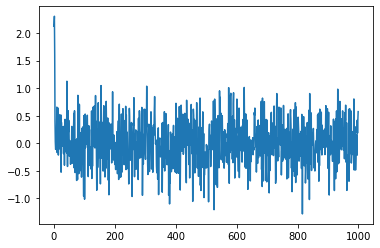

In [61]:
plt.plot((X.T @ Y_obs / 100).reshape(-1))

In [64]:
np.mean(((X.T @ Y_obs / 100).reshape(-1) - true_beta.reshape(-1))**2)

0.1577562275683483

In [37]:
md.eval()
input = np.concatenate((Y_obs, X.T @ Y_obs), axis=0) / normalize_c
input = torch.from_numpy(input.reshape(-1)).type(torch.float)
np.mean((true_beta.reshape(-1) - md(input).detach().numpy().reshape(-1))**2)

0.059622295364918136

In [65]:
(X.T @ Y_obs / 100).reshape(-1)[:6]

array([2.12622556, 2.16600304, 2.30357005, 1.61854618, 0.39269157,
       0.02478868])

In [35]:
md.eval()
input = torch.from_numpy(input.reshape(-1)).type(torch.float)
md(input)

tensor([ 1.2839e+00,  8.0338e-01,  1.1611e+00,  2.0595e+00,  2.9033e+00,
         1.2681e+00,  1.2046e-01,  2.1216e+00,  2.5055e+00,  2.0634e-01,
        -9.0655e-02,  1.9710e-02,  5.0190e-02,  1.4902e-02, -5.2473e-02,
        -5.6995e-03, -3.0074e-02,  5.5772e-02,  4.7390e-02,  1.1610e-02,
        -1.2421e-02,  7.0425e-04,  4.3252e-02, -3.3594e-03, -1.1032e-01,
        -5.0639e-02,  2.1971e-02, -3.1224e-04, -2.3324e-02,  2.9038e-02,
        -7.0651e-03,  3.3595e-02, -1.6065e-02, -8.7441e-02, -2.5137e-02,
        -5.0214e-02,  4.5933e-02,  7.9218e-02,  6.0318e-02,  3.5150e-02,
        -1.9430e-02, -4.4031e-02, -6.3909e-03, -8.7215e-05, -1.3651e-02,
        -5.5641e-02,  8.3080e-02, -2.7941e-02, -3.5848e-02, -5.4697e-02,
         7.7290e-03,  1.3430e-03, -5.6995e-02, -5.2464e-02, -1.9080e-02,
        -1.3694e-02,  1.2679e-02,  5.8757e-02, -2.4944e-02,  1.1691e-01,
         8.4495e-03, -4.2448e-02,  4.3195e-02,  3.3424e-02,  5.7893e-02,
        -2.0115e-02, -6.8507e-02,  6.5563e-02, -3.5

In [12]:
def predict(model, Y):
    model.eval()
    with torch.no_grad():
        data = torch.from_numpy(Y).type(torch.float).to(device)
        pred = model.forward(data)
    return pred

## $\rho=0$

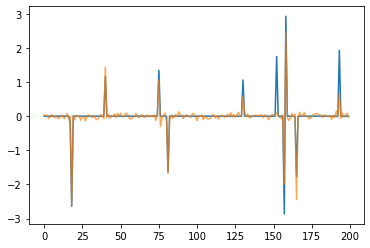

In [13]:
plt.plot(beta_test[0])
plt.plot(predict(md, Y_test[0]/normalize_c).detach().cpu().numpy(), alpha=0.7)

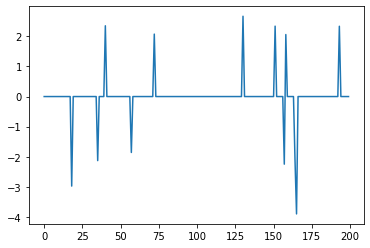

In [77]:
a = X.T @ Y_test[0,:50].T / 50
a[np.abs(a)<1.8]=0
plt.plot(a)

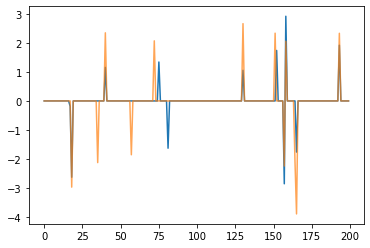

In [78]:
plt.plot(beta_test[0])
plt.plot(a, alpha=0.7)

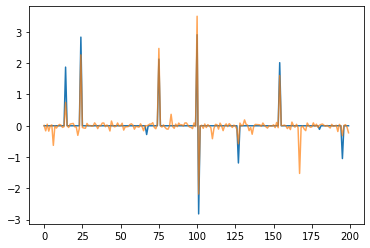

In [79]:
plt.plot(beta_test[1])
plt.plot(predict(md, Y_test[1]/normalize_c).detach().cpu().numpy(), alpha=0.7)

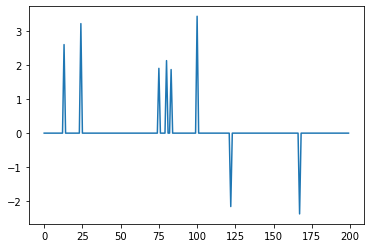

In [56]:
a = X.T @ Y_test[1,:50].T / 50
a[np.abs(a)<1.8]=0
plt.plot(a)

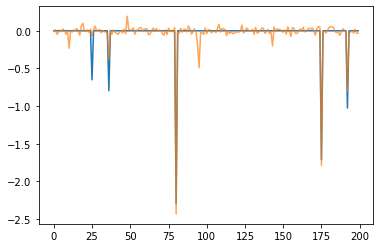

In [14]:
plt.plot(beta_test[2])
plt.plot(predict(md, Y_test[2]/normalize_c).detach().cpu().numpy(), alpha=0.7)

In [15]:
pred = predict(md, Y_test[2]/normalize_c).detach().cpu().numpy()

In [24]:
np.where(np.abs(pred)>0.1)[0]+1

array([ 11,  37,  49,  81,  95,  96, 144, 176, 193], dtype=int64)

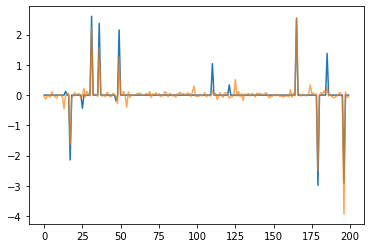

In [47]:
plt.plot(beta_test[3])
plt.plot(predict(md, Y_test[3]/normalize_c).detach().cpu().numpy(), alpha=0.7)

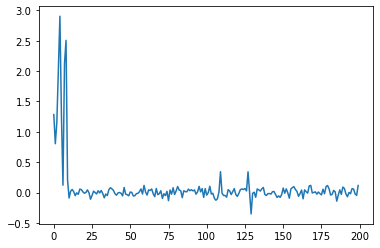

In [36]:
output = md(input).detach().numpy()
plt.plot(output)
plt.show()

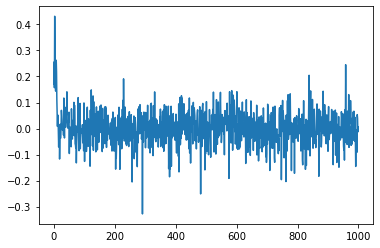

In [53]:
output = md_promax(input).detach().numpy()
plt.plot(output)
plt.show()

### Different $\sigma$

In [86]:
gamma_test_rho0_s2, beta_test_rho0_s2, Y_test_rho0_s2 = generator.generate_samples(100000, sigma=np.sqrt(2))

In [87]:
model_test(md, Y_test_rho0_s2/normalize_c, beta_test_rho0_s2)

0.036307964473962784

In [88]:
gamma_test_rho0_s001, beta_test_rho0_s001, Y_test_rho0_s001 = generator.generate_samples(100000, sigma=np.sqrt(0.01))
model_test(md, Y_test_rho0_s001/normalize_c, beta_test_rho0_s001)

0.02516942471265793

In [89]:
gamma_test_rho0_s005, beta_test_rho0_s005, Y_test_rho0_s005 = generator.generate_samples(100000, sigma=np.sqrt(0.05))
model_test(md, Y_test_rho0_s005/normalize_c, beta_test_rho0_s005)

0.025426872074604034

In [96]:
gamma_test_rho0_s4, beta_test_rho0_s4, Y_test_rho0_s4 = generator.generate_samples(100000, sigma=np.sqrt(4))
model_test(md, Y_test_rho0_s4/normalize_c, beta_test_rho0_s4)

0.04944697022438049

In [97]:
gamma_test_rho0_s8, beta_test_rho0_s8, Y_test_rho0_s8 = generator.generate_samples(100000, sigma=np.sqrt(8))
model_test(md, Y_test_rho0_s8/normalize_c, beta_test_rho0_s8)

0.07699544727802277

In [136]:
print(np.max(np.abs(Y_test)))
print(np.max(np.abs(Y_test_rho0_s2)))
print(np.max(np.abs(Y_test_rho0_s4)))
print(np.max(np.abs(Y_test_rho0_s8)))

398.4533756744768
342.00402091458994
355.9904015550176
378.7122383843274


### Different $\theta$

In [139]:
generator_tho0_theta002 = Generator(p, 0.02, beta_range, N, X, True)
gamma_test_rho0_theta002, beta_test_rho0_theta002, Y_test_rho0_theta002 = generator_tho0_theta002.generate_samples(100000)

In [142]:
np.max(np.abs(Y_test_rho0_theta002))

290.6536631006979

In [147]:
model_test(md, Y_test_rho0_theta002/normalize_c, beta_test_rho0_theta002)

0.004334085155278444

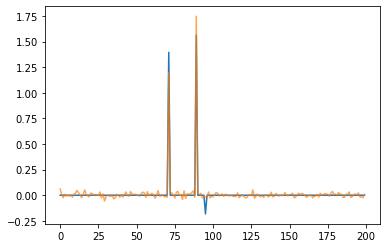

In [143]:
plt.plot(beta_test_rho0_theta002[0])
plt.plot(predict(md, Y_test_rho0_theta002[0]/normalize_c).detach().cpu().numpy(), alpha=0.7)

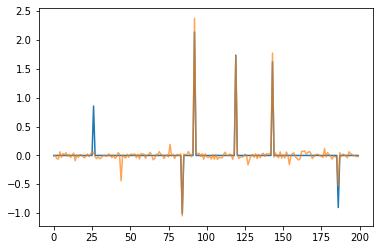

In [144]:
plt.plot(beta_test_rho0_theta002[1])
plt.plot(predict(md, Y_test_rho0_theta002[1]/normalize_c).detach().cpu().numpy(), alpha=0.7)

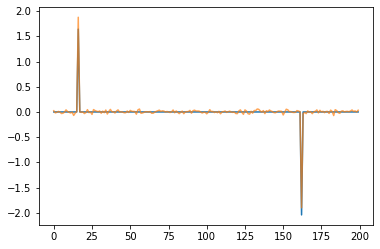

In [145]:
plt.plot(beta_test_rho0_theta002[2])
plt.plot(predict(md, Y_test_rho0_theta002[2]/normalize_c).detach().cpu().numpy(), alpha=0.7)

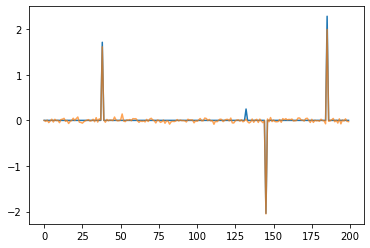

In [146]:
plt.plot(beta_test_rho0_theta002[3])
plt.plot(predict(md, Y_test_rho0_theta002[3]/normalize_c).detach().cpu().numpy(), alpha=0.7)

In [148]:
generator_tho0_theta008 = Generator(p, 0.08, beta_range, N, X, True)
gamma_test_rho0_theta008, beta_test_rho0_theta008, Y_test_rho0_theta008 = generator_tho0_theta008.generate_samples(100000)

In [149]:
np.max(np.abs(Y_test_rho0_theta008))

403.371227621457

In [150]:
model_test(md, Y_test_rho0_theta008/normalize_c, beta_test_rho0_theta008)

0.09644144773483276

In [7]:
generator_tho0_theta01 = Generator(p, 0.1, beta_range, N, X, True)
gamma_test_rho0_theta01, beta_test_rho0_theta01, Y_test_rho0_theta01 = generator_tho0_theta01.generate_samples(100000)

In [8]:
np.max(np.abs(Y_test_rho0_theta01))

435.2069006262543

In [14]:
model_test(md, Y_test_rho0_theta01/normalize_c, beta_test_rho0_theta01)

0.1565827876329422

## $\rho=0.6$

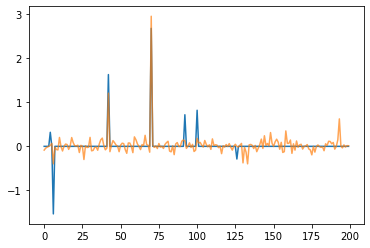

In [64]:
plt.plot(beta_test_rho06[0])
plt.plot(predict(md_rho06, Y_test_rho06[0]/normalize_c_rho_06).detach().cpu().numpy(), alpha=0.7)

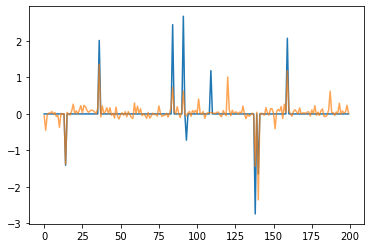

In [65]:
plt.plot(beta_test_rho06[1])
plt.plot(predict(md_rho06, Y_test_rho06[1]/normalize_c_rho_06).detach().cpu().numpy(), alpha=0.7)

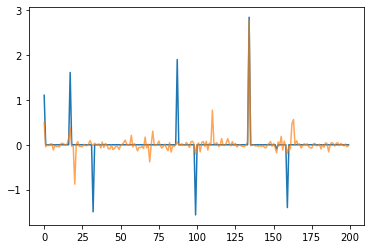

In [66]:
plt.plot(beta_test_rho06[2])
plt.plot(predict(md_rho06, Y_test_rho06[2]/normalize_c_rho_06).detach().cpu().numpy(), alpha=0.7)

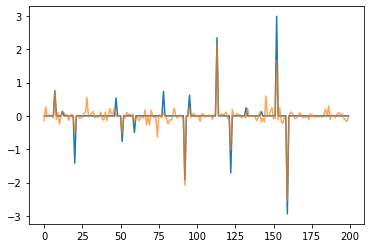

In [67]:
plt.plot(beta_test_rho06[3])
plt.plot(predict(md_rho06, Y_test_rho06[3]/normalize_c_rho_06).detach().cpu().numpy(), alpha=0.7)

### Different $\sigma$

In [126]:
gamma_test_rho06_s001, beta_test_rho06_s001, Y_test_rho06_s001 = generator_rho06.generate_samples(100000, sigma=np.sqrt(0.01))
model_test(md_rho06, Y_test_rho06_s001/normalize_c_rho_06, beta_test_rho06_s001)

0.060765963047742844

In [129]:
gamma_test_rho06_s005, beta_test_rho06_s005, Y_test_rho06_s005 = generator_rho06.generate_samples(100000, sigma=np.sqrt(0.05))
model_test(md_rho06, Y_test_rho06_s005/normalize_c_rho_06, beta_test_rho06_s005)

0.06078750640153885

In [130]:
gamma_test_rho06_s2, beta_test_rho06_s2, Y_test_rho06_s2 = generator_rho06.generate_samples(100000, sigma=np.sqrt(2))
model_test(md_rho06, Y_test_rho06_s2/normalize_c_rho_06, beta_test_rho06_s2)

0.0795661136507988

In [131]:
gamma_test_rho06_s4, beta_test_rho06_s4, Y_test_rho06_s4 = generator_rho06.generate_samples(100000, sigma=np.sqrt(4))
model_test(md_rho06, Y_test_rho06_s4/normalize_c_rho_06, beta_test_rho06_s4)

0.0995214655995369

In [132]:
gamma_test_rho06_s8, beta_test_rho06_s8, Y_test_rho06_s8 = generator_rho06.generate_samples(100000, sigma=np.sqrt(8))
model_test(md_rho06, Y_test_rho06_s8/normalize_c_rho_06, beta_test_rho06_s8)

0.13599799573421478

In [15]:
import pandas as pd

In [20]:
np.savetxt('../X_rho0.csv', X, delimiter=',')
np.savetxt('../Y_rho0_test.csv', Y_test[:4,:50], delimiter=',')
np.savetxt('../beta_rho0_test.csv', beta_test[:4,:], delimiter=',')